In [1]:
#!pip install kaggle
import os
import networkx as nx
import pandas as pd
import numpy as np
from pathlib import Path
import zipfile
import matplotlib.pyplot as plt
from networkx.algorithms import bipartite
import random

Data from: https://www.kaggle.com/leomauro/smmnet

# Datenbeschaffung & Aufbereitung

## Setup kaggle api

In [2]:
# Create .kaggle path in user dir if not exists
if not os.path.exists(str(Path.home())+"\.kaggle"):
    os.makedirs(str(Path.home())+"\.kaggle")

Go to www.<span>kaggle.<span>com/**your_username**/account and download a new api-token. 
After downloading the json file needs to be put into the C:\Users\\**username**\\.kaggle directory.

## Download dataset

In [3]:
# Check if folder already exists
if not os.path.isdir('./data'):
    
    # if not create data folder
    os.makedirs('./data') 
    
    # download csv's
    !kaggle datasets download -d "leomauro/smmnet" -p "./data"

## Unzip files

In [4]:
file_list = ["clears.csv","course-meta.csv","courses.csv","likes.csv","players.csv","plays.csv","records.csv"]
files_exist = []

# Check if all csv's exist
for file in file_list:
    files_exist.append(os.path.isfile("./data/" + file))
    
# if not create csv's
if not all(files_exist):
    with zipfile.ZipFile("./data/smmnet.zip", 'r') as zip_ref:
        zip_ref.extractall("./data") 

## Import files as Pandas DataFrame

In [5]:
clears = pd.read_csv("./data/clears.csv", delimiter = "\t")
course_meta = pd.read_csv("./data/course-meta.csv", delimiter = "\t") # index_col=["id","firstClear"]
courses = pd.read_csv("./data/courses.csv", delimiter = "\t")
likes = pd.read_csv("./data/likes.csv", delimiter = "\t")
players = pd.read_csv("./data/players.csv", delimiter = "\t")
plays = pd.read_csv("./data/plays.csv", delimiter = "\t")
records = pd.read_csv("./data/records.csv", delimiter = "\t")

# Data Validation

# EDA

### Welche Nationalitäten sind unter den Spielern am häuffingsten vertreten?

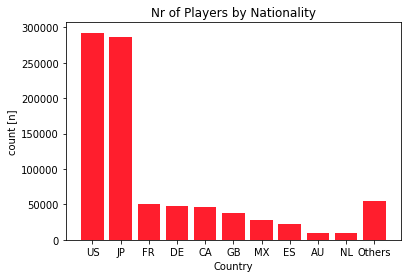

US        292471
JP        286507
FR         50212
DE         48182
CA         46110
GB         37282
MX         28017
ES         22070
AU          9651
NL          9475
Others     54325
dtype: int64

In [6]:
def player_nationalities(top_n):
    nationalities = players.copy()
    nationalities["count"] = 1
    nationalities = nationalities.groupby("flag").count()["count"].sort_values(ascending=False)
    top_nationalities = nationalities[0:top_n].append(pd.Series(nationalities[top_n:].sum()))
    new_index = list(top_nationalities.index)
    new_index[-1] = "Others"
    top_nationalities.index=new_index

    plt.bar(x=top_nationalities.index, height=top_nationalities, color="#FF1E2D")
    plt.title("Nr of Players by Nationality")
    plt.xlabel("Country")
    plt.ylabel("count [n]")
    plt.show()
    
    return top_nationalities

player_nationalities(top_n=10)

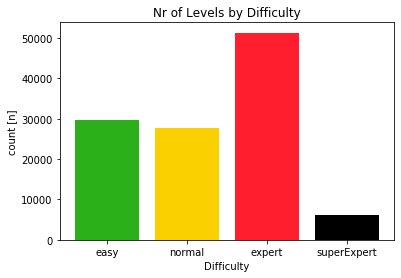

In [7]:
def level_difficilties():
    course_difficulties = courses.groupby("difficulty").count()
    colors = ["#2CB01A","#FBD000", "#FF1E2d", "#000000"]
    plt.bar(x=["easy", "normal", "expert", "superExpert"], height=course_difficulties["id"], color = colors)
    plt.title("Nr of Levels by Difficulty")
    plt.xlabel("Difficulty")
    plt.ylabel("count [n]")
    plt.show()
    
level_difficilties()

# Social Network Analysis

## Player-Level interaction

The dataset contains the two tables "players" which contains all players and the table "plays" which contains all interactions of these players with a level. If we merge these two datasets together, we are able to create a network of all interactions between players and levels

### Create Graph

In [8]:
#merge players df with plays df
player_game_interactions = pd.merge(players, plays.rename(columns={"id": "level_id"}), how="left", left_on="id", right_on="player")

player_level_interactions = nx.Graph()

player_nodes = list(player_game_interactions["id"].unique())
level_nodes = list(player_game_interactions["level_id"].unique())
edges = player_game_interactions[["player", "level_id"]].values.tolist()


player_level_interactions.add_nodes_from(player_nodes)
player_level_interactions.add_nodes_from(level_nodes)
player_level_interactions.add_edges_from(edges)

print(nx.info(player_level_interactions))

Name: 
Type: Graph
Number of nodes: 999335
Number of edges: 3941379
Average degree:   7.8880


The graph has a total of 999'335 nodes (players + levels) and 3'941'379 edges. The average node degree is 7.89. Due to the large number of nodes, it is not possible to visualize the complete graph for reasons of overview and lack of computing power. However, we can examine the graph more closely for it's attributes.

### Node degrees 
he node degrees of the players correspond to the number of different levels they have interacted with. The first attempt to read out the node degrees via networkX and display them as a histogram took too long. 

In [9]:
def plot_player_degrees_nx(player_game_interactions):
    # Braucht zu lange.
    deg_levels, deg_players = bipartite.degrees(player_level_interactions, player_nodes)
    deg_players = dict(deg_players)
    plt.bar(list(deg_players.keys()), deg_players.values(), color="#3944BC")
    plt.show()

Alternatively, the required data was therefore generated here directly from the data frame:

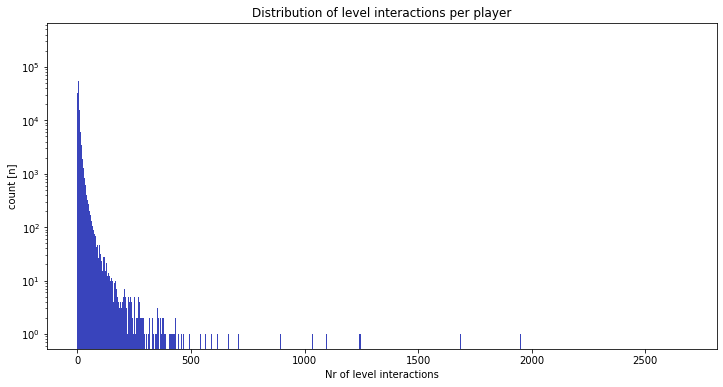

Quantiles:
0.00       0.0
0.25       1.0
0.50       2.0
0.75       4.0
1.00    2681.0
Name: interactions, dtype: float64


In [10]:
def plot_player_degrees_pd(player_game_interactions):
    data = player_game_interactions.groupby("id").count().reset_index().rename(columns={"player": "interactions"})

    plt.figure(figsize=(12, 6))
    plt.hist(data["interactions"], bins=range(min(data["interactions"]), max(data["interactions"]) + 1, 1), color="#3944BC")
    plt.yscale('log')
    plt.title("Distribution of level interactions per player")
    plt.xlabel("Nr of level interactions")
    plt.ylabel("count [n]")
    plt.show()
    return data.drop(columns=["image","flag","name","catch","level_id"]).sort_values("interactions", ascending=False).reset_index(drop=True)
    
node_degrees = plot_player_degrees_pd(player_game_interactions)
print("Quantiles:")
print(node_degrees["interactions"].quantile([0,0.25,0.5,0.75,1]))

Most players have interacted with view different levels. Overall 75 percent of all players have only interacted with four or less levels within the comunity. The median node degree is only at 2. However there are some players that have a very large node degree. Lets have a look at them:

In [11]:
print("10 most interactive players:\n")
print(node_degrees.loc[node_degrees["interactions"]>=1000])

10 most interactive players:

                  id  interactions
0    Conducteur59220          2681
1           dellbox2          1951
2            AE4WiiU          1686
3           revolv23          1437
4   demonhunter47223          1246
5       WIIMoustique          1244
6   buddy1943indiana          1242
7    Plusbellelavie5          1234
8      Feuxdelamoule          1096
9         cowboye123          1068
10     quentintheret          1035
11          Tylano64          1010


The most active player has interacted with a total of 2681 levels. Overall there are twelve players that have over 1000 level interactions. Which explains why the average node degree at 7.9 is nearly four times higher than the median at 2.

In [12]:
def top_n_players(players, plays, n):
    #merge players df with plays df
    player_game_interactions = pd.merge(players, plays.rename(columns={"id": "level_id"}), how="left", left_on="id", right_on="player")
    #Level interaction of top n interacting players
    top_n_players = player_game_interactions.groupby("player").count().nlargest(n,'id').reset_index()["player"].tolist()
    n_player_interactions = player_game_interactions.loc[player_game_interactions['player'].isin(top_n_players)].reset_index(drop=True)
    return n_player_interactions

n = 12
n_player_interactions = top_n_players(players, plays, n)

In [13]:
big_n = nx.Graph()

player_nodes = list(n_player_interactions["player"].unique())
level_nodes = list(n_player_interactions["level_id"].unique())
edges = n_player_interactions[["player", "level_id"]].values.tolist()


big_n.add_nodes_from(player_nodes)
big_n.add_nodes_from(level_nodes)
big_n.add_edges_from(edges, weight=0.5)

pos = nx.drawing.layout.spring_layout(big_n, seed=28)

# plt.figure(figsize=(20, 20))
# ax = plt.gca()
# ax.set_title("Level interactions of " + str(n) + " most interacting players")

# nx.draw_networkx_nodes(big_n, pos, nodelist=level_nodes, node_color="#FF1E2D", node_size=1)  
# nx.draw_networkx_nodes(big_n, pos, nodelist=player_nodes, node_color="#3944BC", node_size=4)                                                                                                        
                                                                                                      
# nx.draw_networkx_edges(big_n, pos)

# plt.savefig("Level interaction of " + str(n) + " most interacting players.png", dpi=800, format="PNG")

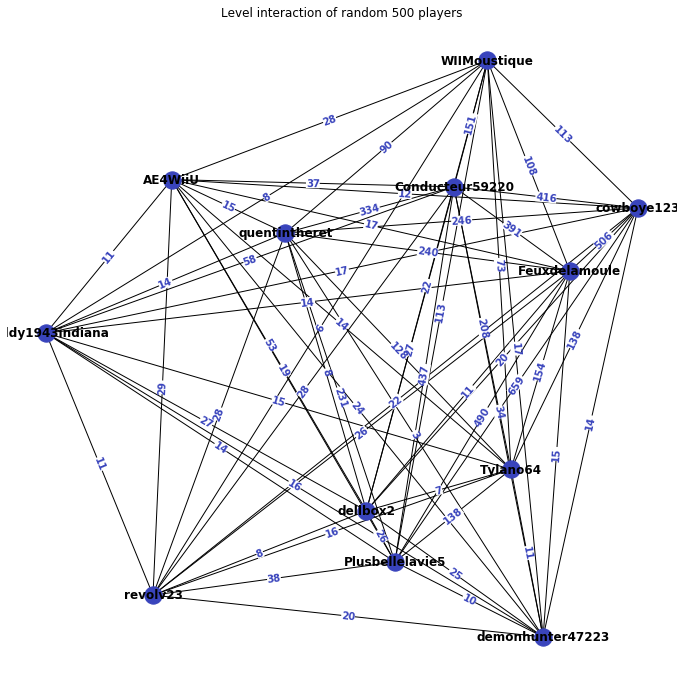

In [14]:
weighted_projection = bipartite.weighted_projected_graph(big_n, player_nodes)
weighted_projection

plt.figure(figsize=(12, 12))
ax = plt.gca()
ax.set_title('Level interaction of random 500 players')
pos = nx.drawing.layout.random_layout(weighted_projection, seed = 10)
# nx.draw_networkx_nodes(weighted_projection, pos, node_color="#3944BC")   
# nx.draw_networkx_labels(weighted_projection, pos)

edge_labels=dict([((u,v,),d['weight'])
             for u,v,d in weighted_projection.edges(data=True)])

nx.draw(weighted_projection, pos, with_labels=True, connectionstyle='arc3', node_color = "#3944BC", font_weight='heavy')
nx.draw_networkx_edge_labels(weighted_projection, 
                             pos, edge_labels=edge_labels, 
                             label_pos=0.5, font_size=10, 
                             font_weight='heavy', 
                             font_color="#3944BC", 
                             bbox=dict(facecolor='white',edgecolor='none',alpha=1, pad=0.0))

plt.draw()
plt.show()

In [15]:
edge_weights =dict(edge_labels)
{k: v for k, v in sorted(edge_weights.items(), key=lambda edge_weights: edge_weights[1], reverse=True)}

{('cowboye123', 'Plusbellelavie5'): 659,
 ('Feuxdelamoule', 'cowboye123'): 506,
 ('Feuxdelamoule', 'Plusbellelavie5'): 490,
 ('Conducteur59220', 'Plusbellelavie5'): 437,
 ('Conducteur59220', 'cowboye123'): 416,
 ('Conducteur59220', 'Feuxdelamoule'): 391,
 ('Conducteur59220', 'quentintheret'): 334,
 ('cowboye123', 'quentintheret'): 246,
 ('Feuxdelamoule', 'quentintheret'): 240,
 ('Plusbellelavie5', 'quentintheret'): 231,
 ('Conducteur59220', 'Tylano64'): 208,
 ('Feuxdelamoule', 'Tylano64'): 154,
 ('Conducteur59220', 'WIIMoustique'): 151,
 ('Tylano64', 'Plusbellelavie5'): 138,
 ('Tylano64', 'cowboye123'): 138,
 ('Tylano64', 'quentintheret'): 128,
 ('WIIMoustique', 'Plusbellelavie5'): 113,
 ('WIIMoustique', 'cowboye123'): 113,
 ('WIIMoustique', 'Feuxdelamoule'): 108,
 ('WIIMoustique', 'quentintheret'): 90,
 ('WIIMoustique', 'Tylano64'): 73,
 ('Conducteur59220', 'buddy1943indiana'): 58,
 ('dellbox2', 'AE4WiiU'): 53,
 ('revolv23', 'Plusbellelavie5'): 38,
 ('Conducteur59220', 'AE4WiiU'): 37,

In [16]:
def random_n_players(players, plays, n):
    #merge players df with plays df
    player_game_interactions = pd.merge(players, plays.rename(columns={"id": "level_id"}), how="left", left_on="id", right_on="player")
    # Filter for random n players
    n_random_players = random.sample(set(player_game_interactions["player"]), 500)
    n_player_interactions = player_game_interactions.loc[player_game_interactions['player'].isin(n_random_players)].reset_index(drop=True)
    return n_player_interactions

n_player_interactions = random_n_players(players, plays, 500)
n_player_interactions.head()

,id,image,flag,name,catch,level_id,player
0,olive149,http://mii-images.cdn.nintendo.net/gjdthhgsqzb...,US,jollybear,2017-11-16 14:46:11.544,093A-0000-0358-2EA9,olive149
1,olive149,http://mii-images.cdn.nintendo.net/gjdthhgsqzb...,US,jollybear,2018-02-23 15:05:45.876,3620-0000-033B-9716,olive149
2,olive149,http://mii-images.cdn.nintendo.net/gjdthhgsqzb...,US,jollybear,2018-03-02 10:01:37.496,CED7-0000-0363-40DA,olive149
3,olive149,http://mii-images.cdn.nintendo.net/gjdthhgsqzb...,US,jollybear,2018-02-23 14:59:44.172,FE2D-0000-034C-7887,olive149
4,littlelionwoman,http://mii-images.cdn.nintendo.net/2d1bz4ku804...,US,PotatoBake,2018-02-23 15:04:02.791,05D8-0000-031D-9061,littlelionwoman


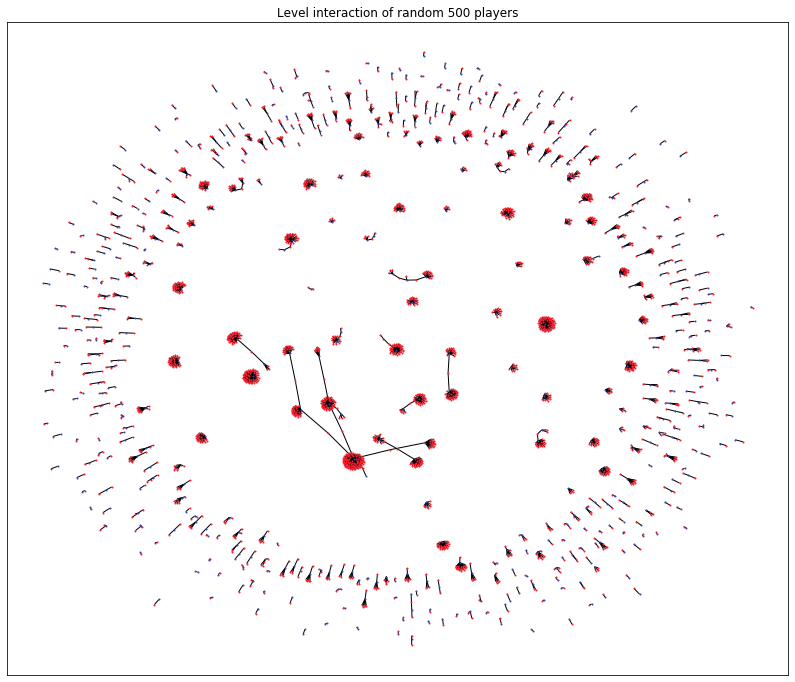

In [19]:
random_n = nx.Graph()

player_nodes = list(n_player_interactions["player"].unique())
level_nodes = list(n_player_interactions["level_id"].unique())
edges = n_player_interactions[["player", "level_id"]].values.tolist()

random_n.add_nodes_from(player_nodes)
random_n.add_nodes_from(level_nodes)
random_n.add_edges_from(edges)

pos = nx.drawing.layout.spring_layout(random_n, seed=98)

plt.figure(figsize=(14, 12))
ax = plt.gca()
ax.set_title('Level interaction of random 500 players')

nx.draw_networkx_nodes(random_n, pos, nodelist=level_nodes, node_color="#FF1E2D", node_size=1)  
nx.draw_networkx_nodes(random_n, pos, nodelist=player_nodes, node_color="#3944BC", node_size=1)                                                                                                        
                                                                                                      
nx.draw_networkx_edges(random_n, pos)

plt.savefig("Level interaction of random 500 players.png", dpi=800, format="PNG")